In [1]:
import pandas as pd
import tueplots as tue 
from tueplots import bundles
from tueplots.constants.color import rgb
from tueplots.constants.color import palettes
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tueplots.constants import markers as marker_constants
import numpy as np
import joypy
import warnings
import concurrent.futures

In [2]:
# Merge all dataframes and rename the count columns
def rename_merge(dataframes, suffixes):
    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i].copy()
        dataframes[i].rename(columns={'count': f'count_{suffixes[i]}'}, inplace=True)

    merge_df = dataframes[0]

    for dataframe in dataframes[1:]:
        merge_df = merge_df.merge(dataframe, how='outer', on='frame.time')

    return merge_df.dropna()

In [3]:
# To suppress all warnings
warnings.filterwarnings("ignore")

```python
    # example of set plot stylesheet 
    plt.rcParams.update(bundles.icml2023(column='full', nrows=1, ncols=2, usetex=False))

    plt.savefig('figname_cml.pdf')

``````

# load data as csv files

In [4]:
onedrive_path = r"C:\Users\Philipp\OneDrive - UT Cloud"
dMonday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/080124Monday.csv')
print("Monday loaded")
dTuesday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/090124Tuesday.csv')
print("Tuesday loaded")
dWednesday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/100124Wednesday.csv')
print("Wednesday loaded")
dThursday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/110124Thursday.csv')
print("Thursday loaded")
dFriday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/120124Friday.csv')
print("Friday loaded")

Monday loaded
Tuesday loaded
Wednesday loaded
Thursday loaded
Friday loaded


## Change data types and reasure right loaded csv

In [20]:
def changeDataTypes(data, day):

    try: 
        data['frame.time'] = pd.to_datetime(data['frame.time'], format='ISO8601')
        data = data.drop('Unnamed: 0', axis=1)
        data = data.reset_index(drop=True)
    except Exception as e:
        print(f"There was the exception: {e} in {day}")
    
    print(f"{day} time processed")

    return data

In [22]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    dMonday_future = executor.submit(changeDataTypes, dMonday, "Monday")
    dTuesday_future = executor.submit(changeDataTypes, dTuesday, "Tuesday")
    dWednesday_future = executor.submit(changeDataTypes, dWednesday, "Wednesday")
    dThursday_future = executor.submit(changeDataTypes, dThursday, "Thursday")
    dFriday_future = executor.submit(changeDataTypes, dFriday, "Friday")

dMonday = dMonday_future.result()
dTuesday = dTuesday_future.result()
dWednesday = dWednesday_future.result()
dThursday = dThursday_future.result()
dFriday = dFriday_future.result()

There was the exception: "['Unnamed: 0'] not found in axis" in Monday
Monday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Tuesday
Tuesday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Wednesday
Wednesday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Friday
Friday time processed
There was the exception: "['Unnamed: 0'] not found in axis" in Thursday
Thursday time processed


# filter data to keep only requested data

In [42]:
# filter for devices that comunicate with an cisco router
def filter(data):
    # data = data.copy()
    eduroam_ssid = '656475726f616d'

    # The ^ tell the regular expression, that it start with the pattern that follows
    cisco_pattern = '^' + '00:f6:63:'

    d_dpa = data.loc[data['_ws.col.protocol'] == 'EAP']

    # Authentication with all cisco devices
    df_dpa_cisco = d_dpa.loc[d_dpa['wlan.sa'].str.match(cisco_pattern)]

    # Authenticated mac addresses as a list
    dpa_cisco_list = df_dpa_cisco['wlan.da'].unique().tolist()

    # All data filterd for eduroam, UTGuest and Guest
    df = data.loc[(data["wlan.ssid"] == eduroam_ssid)|(data["wlan.ssid"] == "55546775657374" )|( data["wlan.ssid"] =="4775657374")]

    # all unique mac addresses with the ssids
    all_sources = df["wlan.sa"].unique().tolist()

    # Combination of mac addresses of the ssids and EPA
    combined_macs = list(set(all_sources + dpa_cisco_list))

    # Check filter 
    diff_elements = [x for x in all_sources if x not in dpa_cisco_list]
    
    # print(f"Number of unqiue mac addresses verfied by cisco: {df_dpa_cisco['wlan.da'].nunique()}")
    # print(f"Number of unqiue mac addresses verfied by ssid: {len(all_sources)}")
    # print(f"Number of elemtents in ssid without cisco {len(diff_elements)}")
    # print(f"Number of elemtents in ssid combined with cisco {len(combined_macs)}")


    # Drop NaNs and sort for time
    data.dropna(subset=['wlan.sa'], inplace = True)
    data['wlan.ssid'].value_counts().sort_index(inplace=True)


    # All entries that use the resulting mac addresses
    return data.loc[data['wlan.sa'].isin(combined_macs)]

In [43]:
# use filter method
dFilteredMonday = filter(dMonday)
dFilteredTuesday  = filter(dTuesday)
dFilteredWednesday  = filter(dWednesday)
dFilteredThursday  = filter(dThursday)
dFilteredFriday  = filter(dFriday)

# Create Dataframe first and last seen

In [44]:
dFirstMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()

# Create Dataframe count of first and last seen add

In [45]:
dCountFirstMonday = pd.DataFrame(dFirstMonday['frame.time'].value_counts().sort_index())
dCountLastMonday = pd.DataFrame(dLastMonday['frame.time'].value_counts().sort_index())
dCountFirstTuesday = pd.DataFrame(dFirstTuesday['frame.time'].value_counts().sort_index())
dCountLastTuesday = pd.DataFrame(dLastTuesday['frame.time'].value_counts().sort_index())
dCountFirstWednesday = pd.DataFrame(dFirstWednesday['frame.time'].value_counts().sort_index())
dCountLastWednesday = pd.DataFrame(dLastWednesday['frame.time'].value_counts().sort_index())
dCountFirstThursday = pd.DataFrame(dFirstThursday['frame.time'].value_counts().sort_index())
dCountLastThursday = pd.DataFrame(dLastThursday['frame.time'].value_counts().sort_index())
dCountFirstFriday = pd.DataFrame(dFirstFriday['frame.time'].value_counts().sort_index())
dCountLastFriday = pd.DataFrame(dLastFriday['frame.time'].value_counts().sort_index())

# Create Dataframe count of frist and last sean mac add every x min

In [46]:
# dCountFirstTuesday.reset_index(inplace=True)
# dCountLastTuesday.reset_index(inplace=True)

In [47]:
def ResampleToXTime(periode, data):

    # Set 'time' column as index
    # data.set_index('frame.time', inplace=True)

    # Resample and sum up 'count' every x minutes
    resampled_data = data.resample(periode + 'Min').sum()

    # # Reset index
    resampled_data.reset_index(inplace=True)

    return resampled_data

In [48]:
d5CountFirstMonday = ResampleToXTime('5', dCountFirstMonday)
d5CountLastMonday = ResampleToXTime('5', dCountLastMonday)
d5CountFirstTuesday = ResampleToXTime('5', dCountFirstTuesday)
d5CountLastTuesday = ResampleToXTime('5', dCountLastTuesday)
d5CountFirstWednesday = ResampleToXTime('5', dCountFirstWednesday)
d5CountLastWednesday = ResampleToXTime('5', dCountLastWednesday)
d5CountFirstThursday = ResampleToXTime('5', dCountFirstThursday)
d5CountLastThursday = ResampleToXTime('5', dCountLastThursday)
d5CountFirstFriday = ResampleToXTime('5', dCountFirstFriday)
d5CountLastFriday = ResampleToXTime('5', dCountLastFriday)

In [49]:
def getCumSum(dataFirst, dataLast):
    data = dataLast.copy()
    data['count'] = np.cumsum(dataFirst['count'] - dataLast['count'])
    # data['count'] = np.cumsum(dataFirst['count']) - np.cumsum(dataLast['count'])

    return data

## create week dataset

In [50]:
d5CumSumMonday = getCumSum(d5CountFirstMonday, d5CountLastMonday)
d5CumSumTuesday = getCumSum(d5CountFirstTuesday, d5CountLastTuesday)
d5CumSumWednesday = getCumSum(d5CountFirstWednesday, d5CountLastWednesday)
d5CumSumThursday = getCumSum(d5CountFirstThursday, d5CountLastThursday)
d5CumSumFriday = getCumSum(d5CountFirstFriday, d5CountLastFriday)

d5CumSumWeek = pd.concat([d5CumSumMonday, d5CumSumTuesday, d5CumSumWednesday, d5CumSumThursday, d5CumSumFriday])

In [51]:
#  only keeps the time of data frames
def keepOnlyTime(data):
    data = data.copy()
    data['frame.time'] = data['frame.time'].dt.time.astype(str)
    data["frame.time"] = data["frame.time"].str.replace(r':\d{2}$', '', regex=True)

    return data

In [52]:
# convert to only keep time in string format
d5timeCountFirstMonday = keepOnlyTime(d5CountFirstMonday).sort_index()
d5timeCountLastMonday = keepOnlyTime(d5CountLastMonday).sort_index()
d5timeCountFirstTuesday = keepOnlyTime(d5CountFirstTuesday).sort_index()
d5timeCountLastTuesday = keepOnlyTime(d5CountLastTuesday).sort_index()
d5timeCountFirstWednesday = keepOnlyTime(d5CountFirstWednesday).sort_index()
d5timeCountLastWednesday = keepOnlyTime(d5CountLastWednesday).sort_index()
d5timeCountFirstThursday = keepOnlyTime(d5CountFirstThursday).sort_index()
d5timeCountLastThursday = keepOnlyTime(d5CountLastThursday).sort_index()
d5timeCountFirstFriday = keepOnlyTime(d5CountFirstFriday).sort_index()
d5timeCountLastFriday = keepOnlyTime(d5CountLastFriday).sort_index()

# Queue 


In [53]:
# unique macs to number of people using descrete distribution
def random_counts(enter_count):
   r = np.random.uniform(0, 1, enter_count)
   r_c = np.ones_like(r)
   r_c = np.where(r >= 0.85, np.where(r >= 0.90, 0, 2 ), 1)
   return r_c.sum()

In [54]:
d1timeCountLastMonday = keepOnlyTime(ResampleToXTime('1',dCountLastMonday))
d1timeCountLastTuesday = keepOnlyTime(ResampleToXTime('1',dCountLastTuesday))
d1timeCountLastWednesday = keepOnlyTime(ResampleToXTime('1',dCountLastWednesday))
d1timeCountLastThursday = keepOnlyTime(ResampleToXTime('1',dCountLastThursday))
d1timeCountLastFriday = keepOnlyTime(ResampleToXTime('1',dCountLastFriday))

In [55]:
d1timeCountFirstMonday = keepOnlyTime(ResampleToXTime('1',dCountFirstMonday))
d1timeCountFirstTuesday = keepOnlyTime(ResampleToXTime('1',dCountFirstTuesday))
d1timeCountFirstWednesday = keepOnlyTime(ResampleToXTime('1',dCountFirstWednesday))
d1timeCountFirstThursday = keepOnlyTime(ResampleToXTime('1',dCountFirstThursday))
d1timeCountFirstFriday = keepOnlyTime(ResampleToXTime('1',dCountFirstFriday))

d5timeCountLastMonday

,frame.time,count
0,11:10,2
1,11:15,0
2,11:20,3
3,11:25,4
4,11:30,6
5,11:35,24
6,11:40,14
7,11:45,15
8,11:50,43
9,11:55,45


In [56]:
d1CumSumMonday = getCumSum(d1timeCountFirstMonday, d1timeCountLastMonday)
d1CumSumTuesday = getCumSum(d1timeCountFirstTuesday, d1timeCountLastTuesday)
d1CumSumWednesday = getCumSum(d1timeCountFirstWednesday, d1timeCountLastWednesday)
d1CumSumThursday = getCumSum(d1timeCountFirstThursday, d1timeCountLastThursday)
d1CumSumFriday = getCumSum(d1timeCountFirstFriday, d1timeCountLastFriday)

In [57]:
# temp plotting function for comparing queue models
def plotQueue(dFrist, dSumCount, title, ticks):
    
    datamerged = rename_merge([dSumCount, dFrist], ['CumSum', 'First'])

    plt.plot(datamerged['frame.time'], datamerged['queue_count'].to_numpy(), label='Queue')
    plt.plot(datamerged['frame.time'], datamerged['count_CumSum'], label='Total count')
    plt.plot(datamerged['frame.time'], datamerged['count_First'], label='First seen count')
    plt.title(title)
    plt.ylabel('unique macs / min')
    plt.xlabel('time')

    locsy, labels = plt.yticks()
    locs, labels = plt.xticks()
    plt.yticks(np.linspace(min(locsy), max(locsy), num=9))
    plt.xticks(locs[::ticks])
    plt.grid(True)
    plt.legend()

    plt.show()

## Naive queue model

In [58]:
def naive_queue_model(nr_counters, serving_speed, countFirst):
    
    # Initialize queue_count column
    queueCount = countFirst.copy()
    queueCount['queue_count'] = 0

    # Calculate queue count for each minute
    for i in range(len(queueCount)):
        #print(i)
        if i == 0: #timepoint 0
            queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count'].iloc[i] - nr_counters * serving_speed)
        else:
            queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count'].iloc[i] - nr_counters * serving_speed)

    return queueCount
    

In [59]:
def queue_model(nr_counters, serving_speed, countFirst):
    
    # Initialize queue_count column
    queueCount = countFirst.copy()
    queueCount['queue_count'] = 0

    # Calculate queue count for each minute
    for i in range(len(queueCount)):
        #print(i)
        if i == 0: #timepoint 0
            queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count'].iloc[i] - nr_counters * serving_speed)
        else:
            queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count'].iloc[i] - nr_counters * serving_speed)

    return queueCount
    

# Plot Results


In [62]:
plotQueue(naive_queue_model(3, 30, d5timeCountLastMonday),d5CumSumWednesday , 'naive queue model Wednesday', 2)

ValueError: You are trying to merge on datetime64[ns, UTC+01:00] and object columns for key 'frame.time'. If you wish to proceed you should use pd.concat

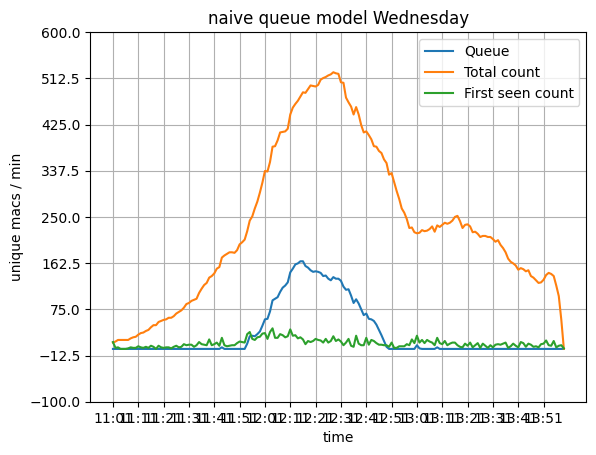

In [63]:
plotQueue(naive_queue_model(3, 6, d1timeCountFirstWednesday),d1CumSumWednesday , 'naive queue model Wednesday', 10 )

In [64]:
d5WeekFirst = rename_merge([d5timeCountFirstMonday, d5timeCountFirstTuesday, d5timeCountFirstWednesday, d5timeCountFirstThursday, d5timeCountFirstFriday ], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


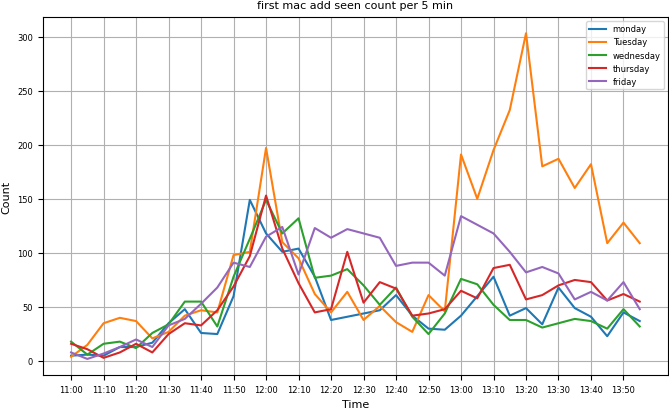

In [67]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

plt.plot(d5WeekFirst['frame.time'], d5WeekFirst['count_Monday'], label='monday')
plt.plot(d5WeekFirst['frame.time'], d5WeekFirst['count_Tuesday'], label='Tuesday')
plt.plot(d5WeekFirst['frame.time'], d5WeekFirst['count_Wednesday'], label='wednesday')
plt.plot(d5WeekFirst['frame.time'], d5WeekFirst['count_Thursday'], label='thursday')
plt.plot(d5WeekFirst['frame.time'], d5WeekFirst['count_Friday'], label='friday')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('first mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::2])


plt.savefig('./plots/first_seen_mac_per_5_min.pdf')

In [68]:
d5WeekLast = rename_merge([d5timeCountLastMonday, d5timeCountLastTuesday, d5timeCountLastWednesday, d5timeCountLastThursday, d5timeCountLastFriday ], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


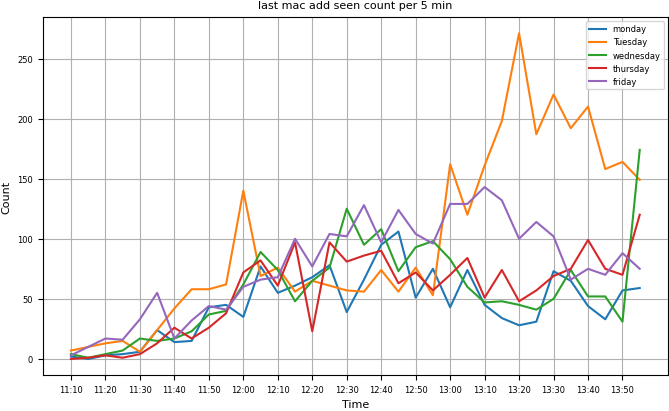

In [69]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

plt.plot(d5WeekLast['frame.time'], d5WeekLast['count_Monday'], label='monday')
plt.plot(d5WeekLast['frame.time'], d5WeekLast['count_Tuesday'], label='Tuesday')
plt.plot(d5WeekLast['frame.time'], d5WeekLast['count_Wednesday'], label='wednesday')
plt.plot(d5WeekLast['frame.time'], d5WeekLast['count_Thursday'], label='thursday')
plt.plot(d5WeekLast['frame.time'], d5WeekLast['count_Friday'], label='friday')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('last mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::2])


plt.savefig('./plots/last_seen_mac_per_5_min.pdf')

## Cumulative sum
subtract frist seen count from last seen count add compute the cumulative sum

In [70]:
d5CumSumMonday = getCumSum(d5timeCountFirstMonday, d5timeCountLastMonday)
d5CumSumTuesday = getCumSum(d5timeCountFirstTuesday, d5timeCountLastTuesday)
d5CumSumWednesday = getCumSum(d5timeCountFirstWednesday, d5timeCountLastWednesday)
d5CumSumThursday = getCumSum(d5timeCountFirstThursday, d5timeCountLastThursday)
d5CumSumFriday = getCumSum(d5timeCountFirstFriday, d5timeCountLastFriday)

In [71]:
d5MondayCumFirstLast = rename_merge([d5CumSumMonday, d5timeCountFirstMonday, d5timeCountLastMonday ], ['CumSum', 'First', 'Last'])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


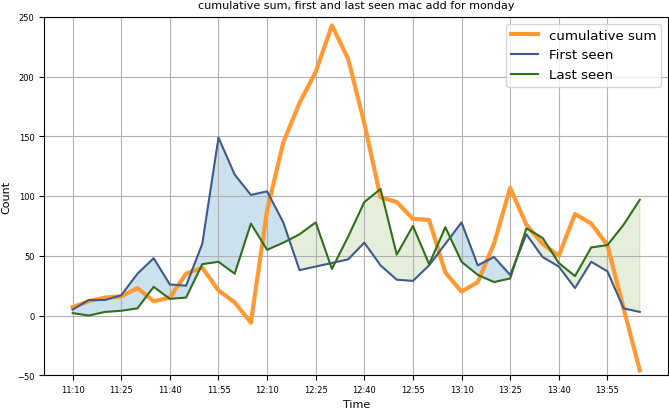

In [72]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
plt.title('cumulative sum, first and last seen mac add for monday')
plt.xlabel('Time')
plt.ylabel('Count')

plt.plot(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_CumSum'], color = rgb.pn_orange, label='cumulative sum', linewidth=3)
plt.plot(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_First'], color = rgb.tue_darkblue, label='First seen')
plt.plot(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_Last'], color = rgb.tue_darkgreen, label='Last seen')

plt.fill_between(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_First'], d5MondayCumFirstLast['count_Last'], where=(d5MondayCumFirstLast['count_First'] > d5MondayCumFirstLast['count_Last']), interpolate=True, color = rgb.tue_blue, alpha = 0.2)
plt.fill_between(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_First'], d5MondayCumFirstLast['count_Last'], where=(d5MondayCumFirstLast['count_First'] <= d5MondayCumFirstLast['count_Last']), interpolate=True, color = rgb.tue_green, alpha = 0.2)
# plt.fill_between(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_CumSum'], color = rgb.tue_blue, alpha = 0.2)

plt.legend()
plt.legend(fontsize='large')
plt.grid(True)

locsy, labels = plt.yticks()
locs, labels = plt.xticks()
plt.yticks(np.linspace(min(locsy), max(locsy), num=9))
plt.xticks(locs[::3])

# plt.xlim([xmin, xmax])
plt.ylim([-50, 250])

plt.savefig('./plots/CumSumFirstLastMonday.pdf')

In [73]:
# merge all dataframe in one dataframe
d5CumSumDaysMerged = rename_merge([d5CumSumMonday,d5CumSumTuesday,d5CumSumWednesday,d5CumSumThursday,d5CumSumFriday], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


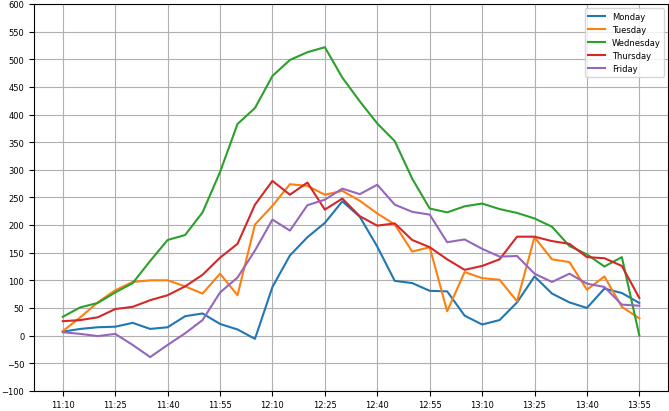

In [74]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Monday'], label='Monday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Tuesday'], label='Tuesday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Wednesday'], label='Wednesday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Thursday'], label='Thursday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Friday'], label='Friday')
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()
plt.legend()
plt.yticks(np.linspace(min(locsy), max(locsy), num=15))
plt.xticks(locsx[::3])
plt.grid(True)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()


In [75]:
# Assuming 'frame.time' is your datetime column
d5CumSumWeek['date'] = d5CumSumWeek['frame.time'].dt.date
d5CumSumWeek['time'] = d5CumSumWeek['frame.time'].dt.time

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


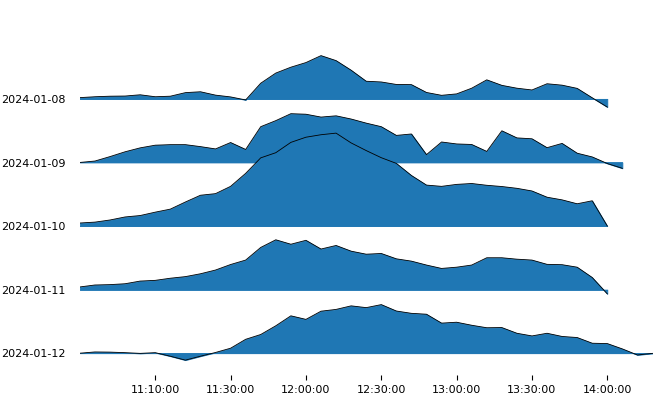

In [76]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
x_range = list(range(39))
labels = d5CumSumWeek['time'].astype(str).drop_duplicates().sort_index()

# Change the x-axis labels
fig, axes = joypy.joyplot(d5CumSumWeek, column='count', by='date', kind="values", x_range = x_range, overlap=1, linewidth=0.6)
axes[-1].set_xticklabels(labels[::6])
plt.savefig('./plots/cumSumWeekJoy.pdf')
plt.show()